In [199]:
%%capture
!pip install apimoex
!pip install requests pandas
!pip install requests beautifulsoup4
!pip install mpl_finance
!pip install mplfinance
!pip install graphviz

In [246]:
import pandas as pd
import numpy as np
import abc
from scipy.stats import norm
import scipy.stats as sts
import matplotlib.dates as mpl_dates 
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from typing import Dict, List, Tuple, Union
from typing import Iterable, List
from graphviz import Digraph

In [10]:
df_ROSN = pd.read_csv('ROSN_after_EDA.csv')  
df_SBER = pd.read_csv('SBER_after_EDA.csv')  
df_LKOH = pd.read_csv('LKOH_after_EDA.csv')  
df_SI = pd.read_csv('SI_after_EDA.csv')  
df_BR = pd.read_csv('BR_after_EDA.csv')  
df_IMOEX = pd.read_csv('IMOEX_after_EDA.csv')  
df_STOCK_AGGREGATE = pd.read_csv('df_STOCK_AGGREGATE.csv')  

In [11]:
df_ROSN_Train = pd.read_csv('ROSN_after_EDA_Last_months.csv')  
df_SBER_Train = pd.read_csv('SBER_after_EDA_Last_months.csv')  
df_LKOH_Train = pd.read_csv('LKOH_after_EDA_Last_months.csv')  
df_SI_Train = pd.read_csv('SI_after_EDA_Last_months.csv')  
df_BR_Train = pd.read_csv('BR_after_EDA_Last_months.csv')  
df_IMOEX_Train = pd.read_csv('IMOEX_after_EDA_Last_months.csv')  
df_STOCK_AGGREGATE_Train = pd.read_csv('df_STOCK_AGGREGATE_Last_months.csv')  

In [12]:
df_IMOEX_Train.set_index('TRADEDATE', inplace=True)
df_STOCK_AGGREGATE_Train.set_index('TRADEDATE', inplace=True)
df_BR_Train.set_index('TRADEDATE', inplace=True)
df_SI_Train.set_index('TRADEDATE', inplace=True)
df_ROSN_Train.set_index('TRADEDATE', inplace=True)

In [13]:
df_ROSN_Train.drop(['Unnamed: 0', 'ADMITTEDQUOTE', 'ADMITTEDVALUE'], axis=1, inplace=True)

In [14]:
df_IMOEX.set_index('TRADEDATE', inplace=True)
df_STOCK_AGGREGATE.set_index('TRADEDATE', inplace=True)
df_BR.set_index('TRADEDATE', inplace=True)
df_SI.set_index('TRADEDATE', inplace=True)
df_ROSN.set_index('TRADEDATE', inplace=True)

In [15]:
df_ROSN.drop(['Unnamed: 0', 'ADMITTEDQUOTE', 'ADMITTEDVALUE'], axis=1, inplace=True)

# **Машинное обучение**

## Прогнозирование среднной цены акций компании Росснефть за торговую сессию

Будем работать лишь с датасетом BR_ROSN. В качестве дополнительных признаков добавим туда информацию об индексе мосбиржи за соответствующие даты информацию о стоимости фьючерсов на нефть и рубль доллар за соответствующий день

In [16]:
df_ROSN

,BOARDID,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,WAPRICE,CLOSE,VOLUME,TRENDCLSPR
TRADEDATE,,,,,,,,,,,
2021-01-04,TQBR,ROSN,22434,2.803388e+09,435.85,433.00,442.60,437.65,436.00,6405540,0.21
2021-01-05,TQBR,ROSN,23452,2.974642e+09,436.00,433.30,450.70,442.10,449.35,6728320,3.06
2021-01-06,TQBR,ROSN,27750,3.697371e+09,449.35,443.70,454.65,449.25,453.70,8230020,0.97
2021-01-08,TQBR,ROSN,42210,6.045034e+09,465.10,463.80,481.00,473.20,478.20,12774820,5.40
2021-01-11,TQBR,ROSN,29306,4.160569e+09,474.55,464.00,480.10,473.05,473.25,8794770,-1.04
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26,TQBR,ROSN,68952,2.624107e+09,559.00,554.15,559.00,555.70,556.10,4720207,-0.35
2024-03-27,TQBR,ROSN,68318,2.007951e+09,556.10,551.25,557.50,554.10,555.40,3623708,-0.13
2024-03-28,TQBR,ROSN,94910,4.580909e+09,557.00,555.75,565.80,561.80,565.75,8154564,1.86


In [17]:
df_ROSN['IMOEX_CLOSE'] = df_IMOEX['CLOSE']
df_ROSN['IMOEX_OPEN'] = df_IMOEX['OPEN']
df_ROSN['BR_WAPRICE'] = df_BR['WAPRICE']
df_ROSN['BR_CLOSE'] = df_BR['CLOSE']
df_ROSN['BR_OPE'] = df_BR['OPEN']
df_ROSN['BR_HIGH'] = df_BR['HIGH']
df_ROSN['BR_LOW'] = df_BR['LOW']
df_ROSN['SI_WAPRICE'] = df_SI['WAPRICE']
df_ROSN['SI_CLOSE'] = df_SI['CLOSE']
df_ROSN['SI_OPE'] = df_SI['OPEN']
df_ROSN['SI_HIGH'] = df_SI['HIGH']
df_ROSN['SI_LOW'] = df_SI['LOW']
columns_to_add = ['TRENDCLSPR', 'NUMTRADES', 'TradingVolume_RUB', 'TradingVolume_CONTR', 'OpenPositionsVolum_RUB', 'OpenPositionsVolum_CONTR', 'MarginRequirements']
df_ROSN_Final = df_ROSN.merge(df_BR[columns_to_add], left_index=True, right_index=True, how='left')
df_ROSN_Final = df_ROSN.merge(df_SI[columns_to_add], left_index=True, right_index=True, how='left')

In [18]:
df_ROSN_Final.dropna(inplace = True)

Опять же удаляем пропуски так как заполнение их среднем или другой статистикой не имеет экономического смысла в силу слишком большого промежутка времени на протяжении которого струткруа финансового рынка значительно менялась.

In [19]:
df_ROSN_Final

,BOARDID,SECID,NUMTRADES_x,VALUE,OPEN,LOW,HIGH,WAPRICE,CLOSE,VOLUME,...,SI_OPE,SI_HIGH,SI_LOW,TRENDCLSPR_y,NUMTRADES_y,TradingVolume_RUB,TradingVolume_CONTR,OpenPositionsVolum_RUB,OpenPositionsVolum_CONTR,MarginRequirements
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2021-01-05,TQBR,ROSN,23452,2.974642e+09,436.00,433.30,450.70,442.10,449.35,6728320,...,74500.0,75818.0,74403.0,0.0043,911840.0,3.042276e+11,4049800.0,1.830614e+11,2449080.0,6187.0
2021-01-06,TQBR,ROSN,27750,3.697371e+09,449.35,443.70,454.65,449.25,453.70,8230020,...,74780.0,74780.0,73908.0,-0.0039,768465.0,2.354906e+11,3168486.0,1.843702e+11,2474568.0,6165.0
2021-01-08,TQBR,ROSN,42210,6.045034e+09,465.10,463.80,481.00,473.20,478.20,12774820,...,74455.0,75350.0,74165.0,0.0036,866939.0,2.745035e+11,3674288.0,1.854175e+11,2478844.0,5061.0
2021-01-11,TQBR,ROSN,29306,4.160569e+09,474.55,464.00,480.10,473.05,473.25,8794770,...,74764.0,75528.0,74510.0,0.0068,819343.0,2.859884e+11,3809695.0,2.081633e+11,2764526.0,5093.0
2021-01-12,TQBR,ROSN,22979,3.357990e+09,475.00,466.25,479.20,474.15,474.40,7084430,...,75254.0,75274.0,74072.0,-0.0155,786687.0,2.823069e+11,3779774.0,2.144555e+11,2894292.0,5010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,TQBR,ROSN,115063,4.745453e+09,556.70,548.50,559.85,552.70,558.05,8585063,...,95330.0,96085.0,94870.0,-0.0020,203417.0,8.776455e+10,921462.0,5.283995e+11,5553740.0,14727.0
2024-03-26,TQBR,ROSN,68952,2.624107e+09,559.00,554.15,559.00,555.70,556.10,4720207,...,95110.0,95354.0,94700.0,0.0008,136058.0,6.105293e+10,642555.0,5.479354e+11,5754294.0,14739.0
2024-03-27,TQBR,ROSN,68318,2.007951e+09,556.10,551.25,557.50,554.10,555.40,3623708,...,95207.0,95308.0,94218.0,-0.0080,217518.0,8.772180e+10,925341.0,5.646384e+11,5976338.0,14642.0


## Предобработка данных перед машинным обучением

In [20]:
df_ROSN_Final.columns

Index(['BOARDID', 'SECID', 'NUMTRADES_x', 'VALUE', 'OPEN', 'LOW', 'HIGH',
       'WAPRICE', 'CLOSE', 'VOLUME', 'TRENDCLSPR_x', 'IMOEX_CLOSE',
       'IMOEX_OPEN', 'BR_WAPRICE', 'BR_CLOSE', 'BR_OPE', 'BR_HIGH', 'BR_LOW',
       'SI_WAPRICE', 'SI_CLOSE', 'SI_OPE', 'SI_HIGH', 'SI_LOW', 'TRENDCLSPR_y',
       'NUMTRADES_y', 'TradingVolume_RUB', 'TradingVolume_CONTR',
       'OpenPositionsVolum_RUB', 'OpenPositionsVolum_CONTR',
       'MarginRequirements'],
      dtype='object')

In [21]:
df_ROSN_Final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749 entries, 2021-01-05 to 2024-03-29
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BOARDID                   749 non-null    object 
 1   SECID                     749 non-null    object 
 2   NUMTRADES_x               749 non-null    int64  
 3   VALUE                     749 non-null    float64
 4   OPEN                      749 non-null    float64
 5   LOW                       749 non-null    float64
 6   HIGH                      749 non-null    float64
 7   WAPRICE                   749 non-null    float64
 8   CLOSE                     749 non-null    float64
 9   VOLUME                    749 non-null    int64  
 10  TRENDCLSPR_x              749 non-null    float64
 11  IMOEX_CLOSE               749 non-null    float64
 12  IMOEX_OPEN                749 non-null    float64
 13  BR_WAPRICE                749 non-null    float64
 14 

Так как мы предсказываем котировки на данный момент лишь для акций компании Роснефть, то первые два признака, а именно BOARDID И SECID являются константнымим, следовательно их можно исключить из датафрейма

In [22]:
df_ROSN_Final.drop(['BOARDID', 'SECID'], axis=1, inplace=True)

In [23]:
df_ROSN_Final

,NUMTRADES_x,VALUE,OPEN,LOW,HIGH,WAPRICE,CLOSE,VOLUME,TRENDCLSPR_x,IMOEX_CLOSE,...,SI_OPE,SI_HIGH,SI_LOW,TRENDCLSPR_y,NUMTRADES_y,TradingVolume_RUB,TradingVolume_CONTR,OpenPositionsVolum_RUB,OpenPositionsVolum_CONTR,MarginRequirements
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2021-01-05,23452,2.974642e+09,436.00,433.30,450.70,442.10,449.35,6728320,3.06,3359.15,...,74500.0,75818.0,74403.0,0.0043,911840.0,3.042276e+11,4049800.0,1.830614e+11,2449080.0,6187.0
2021-01-06,27750,3.697371e+09,449.35,443.70,454.65,449.25,453.70,8230020,0.97,3371.03,...,74780.0,74780.0,73908.0,-0.0039,768465.0,2.354906e+11,3168486.0,1.843702e+11,2474568.0,6165.0
2021-01-08,42210,6.045034e+09,465.10,463.80,481.00,473.20,478.20,12774820,5.40,3454.82,...,74455.0,75350.0,74165.0,0.0036,866939.0,2.745035e+11,3674288.0,1.854175e+11,2478844.0,5061.0
2021-01-11,29306,4.160569e+09,474.55,464.00,480.10,473.05,473.25,8794770,-1.04,3482.48,...,74764.0,75528.0,74510.0,0.0068,819343.0,2.859884e+11,3809695.0,2.081633e+11,2764526.0,5093.0
2021-01-12,22979,3.357990e+09,475.00,466.25,479.20,474.15,474.40,7084430,0.24,3471.65,...,75254.0,75274.0,74072.0,-0.0155,786687.0,2.823069e+11,3779774.0,2.144555e+11,2894292.0,5010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,115063,4.745453e+09,556.70,548.50,559.85,552.70,558.05,8585063,0.69,3281.63,...,95330.0,96085.0,94870.0,-0.0020,203417.0,8.776455e+10,921462.0,5.283995e+11,5553740.0,14727.0
2024-03-26,68952,2.624107e+09,559.00,554.15,559.00,555.70,556.10,4720207,-0.35,3285.54,...,95110.0,95354.0,94700.0,0.0008,136058.0,6.105293e+10,642555.0,5.479354e+11,5754294.0,14739.0
2024-03-27,68318,2.007951e+09,556.10,551.25,557.50,554.10,555.40,3623708,-0.13,3304.09,...,95207.0,95308.0,94218.0,-0.0080,217518.0,8.772180e+10,925341.0,5.646384e+11,5976338.0,14642.0


Для более успешного обучения модели исходные данные необходимо нормализовать, чтобы по итогу модель выдавала более качественный прогноз. Что и с сделаем при помощи min-max нормализатора. Многие алгоритмы машинного обучения, особенно те, которые используют вычисление расстояний между точками данных или градиентный спуск (например, линейная регрессия, логистическая регрессия, нейронные сети), работают лучше, если все признаки имеют одинаковый масштаб. Несбалансированные масштабы могут привести к тому, что некоторые признаки будут доминировать в модели за счёт других, что может ухудшить качество обучения.

Min-Max нормализация не меняет форму распределения данных, а лишь изменяет диапазон. Это может быть полезно, если данные не нуждаются в трансформации для коррекции асимметрии или выбросов.

Этот метод нормализации достаточно прост и интуитивно понятен. Вычисления несложные: каждому значению признака присваивается значение между 0 и 1, что упрощает интерпретацию модели и помогает в диагностике и анализе данных.

Если использовать стандартизацию, то может возникнуть проблема с делением на дисперсию, можно проще...Однако стоит помнить, что Min-Max нормализация может быть чувствительной к наличию выбросов, так как экстремальные значения могут сжать большую часть данных в узкий диапазон. Но, поскольку в наших данных как таковых, выбросов нет - за исключением пару дней в период февраля 22 года, то это можно опустить:
$$x(new)=\dfrac{x-\min(X_{column})}{\max(X_{column})-\min(X_{column})}$$

Сохраним старые значения средних и дисперсий, чтобы использовать для нормализации новых данных.

In [24]:
a = df_ROSN_Final.min()
b = df_ROSN_Final.max()

In [25]:
normalizer = preprocessing.MinMaxScaler()
df_ROSN_Final.columns = df_ROSN_Final.columns.astype(str)
df_ROSN_Final_real_norm_np = normalizer.fit_transform(df_ROSN_Final)
df_ROSN_Final = pd.DataFrame(data=df_ROSN_Final_real_norm_np)

## Линейная модель

In [26]:
df_ROSN_Final.head(10)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.045551,0.082303,0.441783,0.557767,0.464223,0.480648,0.484218,0.076705,0.738926,0.608374,...,0.410563,0.405630,0.470537,0.480826,0.483917,0.460045,0.483088,0.214172,0.233993,0.160811
1,0.056158,0.104199,0.474926,0.580268,0.474175,0.498735,0.495115,0.095744,0.699700,0.613385,...,0.416220,0.383511,0.460339,0.432448,0.395775,0.343518,0.366370,0.216633,0.237930,0.158921
2,0.091843,0.175325,0.514027,0.623756,0.540564,0.559322,0.556488,0.153365,0.782845,0.648731,...,0.409654,0.395657,0.465634,0.476696,0.456314,0.409655,0.433357,0.218602,0.238590,0.064084
3,0.059998,0.118233,0.537488,0.624189,0.538297,0.558943,0.544088,0.102904,0.661974,0.660399,...,0.415897,0.399450,0.472742,0.495575,0.427053,0.429125,0.451290,0.261375,0.282716,0.066833
4,0.044384,0.093917,0.538605,0.629057,0.536029,0.561725,0.546969,0.081220,0.685998,0.655831,...,0.425798,0.394038,0.463718,0.364012,0.406977,0.422884,0.447327,0.273207,0.302760,0.059703
5,0.105419,0.217010,0.543570,0.650692,0.573192,0.589552,0.575902,0.185323,0.727102,0.655245,...,0.402117,0.377224,0.459329,0.458997,0.376878,0.418517,0.446109,0.263708,0.291853,0.059875
6,0.129754,0.224380,0.563431,0.667568,0.602671,0.621300,0.623622,0.186623,0.755068,0.663930,...,0.403289,0.377821,0.455888,0.431858,0.346515,0.420422,0.449264,0.283797,0.315984,0.057985
7,0.126099,0.268503,0.608118,0.698183,0.637944,0.651151,0.641658,0.218273,0.708333,0.647099,...,0.397107,0.374731,0.453643,0.486726,0.352237,0.419757,0.448894,0.286609,0.316765,0.059359
8,0.081508,0.158971,0.625372,0.713436,0.636306,0.660764,0.652430,0.127380,0.697260,0.655945,...,0.404744,0.385279,0.461513,0.484956,0.313497,0.381333,0.404965,0.317483,0.348372,0.061335
9,0.089210,0.187167,0.647592,0.716465,0.650920,0.662408,0.637901,0.150148,0.660473,0.643842,...,0.412664,0.379760,0.462997,0.422419,0.255414,0.311648,0.333233,0.296949,0.328498,0.058500


In [118]:
y = df_ROSN_Final[5]
X = df_ROSN_Final.drop(5, axis = 1)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

Ради практики и интереса будем обучать линейную модель через градиентный спуск. Зря что ли делали домашнее задание по ИАДУ?

In [142]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

In [143]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        Q = np.mean(np.square(X@w-y))
        return Q

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        grad = 2*np.transpose(X)@(X@w-y)/y.shape[0]
        return grad

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [144]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = np.zeros((n_iterations,w_init.shape[0]))
    w[0] = w_init

    for i in range(1,n_iterations):
      w[i] = w[i-1]- lr*loss.calc_grad(X, y, w[i-1])
    return w

Инициализируем вектор случайных весов.

In [145]:
w_init = np.random.uniform(-2, 2, (len(X.columns)))

In [146]:
loss = MSELoss()
w_list = gradient_descent(w_init, X_train, y_train, loss, 0.01, 10000)
print(f' Ошибка MSE после обучения: {loss.calc_loss(X_test, y_test, w_list[-1])}')

 Ошибка MSE после обучения: 0.01514020942014986


In [147]:
w_opt = w_list[-1]

In [148]:
w_opt

array([ 0.79540193, -0.94551524, -0.76185929, -0.14298101, -1.11358911,
        0.20665243, -1.51402196,  0.1727727 ,  2.37651899, -1.36598226,
       -0.20161892, -1.37478109, -0.80067466,  0.17605814,  0.85730601,
        1.30656219,  0.52007492, -1.14874517,  0.89688939,  1.00921586,
        1.53921615, -1.47577945,  1.74442032,  1.37064631, -0.12370711,
       -0.51781217, -0.29115122])

In [221]:
X_test.columns

Index(['NUMTRADES_x', 'VALUE', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOLUME',
       'TRENDCLSPR_x', 'IMOEX_CLOSE', 'IMOEX_OPEN', 'BR_WAPRICE', 'BR_CLOSE',
       'BR_OPE', 'BR_HIGH', 'BR_LOW', 'SI_WAPRICE', 'SI_CLOSE', 'SI_OPE',
       'SI_HIGH', 'SI_LOW', 'TRENDCLSPR_y', 'NUMTRADES_y', 'TradingVolume_RUB',
       'TradingVolume_CONTR', 'OpenPositionsVolum_RUB',
       'OpenPositionsVolum_CONTR', 'MarginRequirements'],
      dtype='object')

Важные признаки (веса по абсолютному значению > 1):
* IMOEX_CLOSE: 2.37651899 (очень важный признак)
* VOLUME: -1.51402196
* TRENDCLSPR_y: 1.53921615
* NUMTRADES_y: -1.47577945
* TradingVolume_RUB: 1.74442032
* BR_CLOSE: -1.37478109
* IMOEX_OPEN: -1.36598226
* BR_OPE: -1.14874517
* SI_WAPRICE: 1.30656219
* TradingVolume_CONTR: 1.37064631

* Закрытие индекса IMOEX (Московская биржа) может быть важным индикатором общего состояния российского фондового рынка, который влияет на акции всех компаний, включая Роснефть и Лукойл.

* Объем торгов в рублях отражает активность на рынке и ликвидность акций, что может быть индикатором интереса инвесторов к данным акциям.

* Трендовая составляющая закрытия акций Лукойла может влиять на Роснефть, поскольку компании находятся в одном секторе (нефтегазовом) и могут иметь схожие рыночные условия и факторы влияния.

* Количество сделок с акциями Лукойла также может быть важным, так как высокое количество сделок указывает на повышенную активность и интерес к нефтегазовому сектору, что может косвенно влиять и на акции Роснефти.

* Закрытие цены на нефть Brent имеет прямое влияние на стоимость акций нефтяных компаний, так как цена нефти влияет на их доходы и прибыль.

* Открытие индекса IMOEX также важно, поскольку показывает направление и настроение рынка в начале торгового дня.

* Средневзвешенная цена фьючерсов на доллар (SI) может влиять на акции, поскольку изменение курса доллара влияет на стоимость экспорта нефти и валютную выручку компании.

* Объем торгов контрактами может отражать ликвидность и интерес к активам, что важно для оценки рыночной активности и настроений инвесторов.

* Общий объем торгов акциями Росснефти также важен, поскольку он показывает ликвидность и интерес к акциям компании.

Данные о Сбере (такие как VALUE, CLOSE, и другие, которые могут относиться к Сберу) оказались наименее важными для нашей модели прогноза котировок акций Росснефти. Это подтверждается тем, что их веса находятся среди наименьших по абсолютному значению.

Предположительно, данные о Сбере оказались менее важными для модели прогноза котировок акций Росснефти по следующим причинам:

Росснефть и Сбербанк принадлежат к разным секторам экономики. Росснефть — это нефтегазовая компания, а Сбербанк — это финансовая организация. Следовательно, их рыночные драйверы и факторы, влияющие на их акции, могут существенно различаться.

Акции нефтяных компаний, таких как Росснефть, сильнее зависят от цен на нефть, курсов валют, глобальных экономических условий и рыночных индексов, чем от показателей финансового сектора.

Хотя показатели крупных финансовых институтов, таких как Сбербанк, могут оказывать некоторое влияние на общий рынок, специфические показатели этих компаний менее значимы для предсказания акций компаний из других секторов, особенно таких специализированных, как нефтегаз.

Таким образом, данные о Сбере оказались наименее важными для нашей модели прогноза котировок акций Росснефти. Это подчеркивает важность выбора релевантных признаков, которые напрямую влияют на предсказываемый актив, и объясняет низкую важность данных о компаниях из других секторов в данном контексте.

Можно, конечно еще добавть коэффициент регуляризации, так как в итоговых весах есть большие веса, что похоже немного на переобучение. Давайте добавим регуляризатор

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

In [149]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        Q = np.mean(np.square(X@w-y)) + self.coef * np.sum(np.square(w))
        return Q

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        y_pred = X.dot(w)
        grad = 2*np.transpose(X)@(y_pred-y)/y.shape[0]
        grad[:-1] += 2 *self.coef*w[:-1]
        return grad

Будем подбирать коэффициент регуляризации по тестовой выборке. Так как это гиперпараметр и его нужно подбирать именно по тестовой выборке

In [150]:
%%capture
alphas = {'alpha': np.arange(0, 100, 0.05)}
lasso_search = GridSearchCV(
    estimator=Lasso(),
    param_grid=alphas,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1)

lasso_search.fit(X_test, y_test)

In [151]:
lasso_search.best_params_

{'alpha': 0.0}

Таким образом, несмотря на вроде бы больше значение весов, оптимальный коэффициент регуляризации в данном случае равен нулю.

# Оценка модели на новых реальных данных

Мы построили линейную модель, которую на самом деле можно оценить на новых данных, а именно наша выборка строилась с 01.01.2021 по 01.04.2024. Так как 1 апреля мы и начили парсить данные, однако теперь, в момент написания этой строчки на календаре 15 мая. А значит нам доступна информация о котировках Роснефти за период, насчитывающий 45 дней. Давайт спарсим эти данные и посчитаем теперь MSE на новой (тестовой) выборке. То есть на то, насколько наш прогноз, полученный при помощи модели будет релевантен по отношению к новым данным

Парсинг был проведен в отдельном документе, так как мы уже множество раз парсили, особенно на первом шаге и повторять один и тот же код - не имело смысла. Поэтому мы просто подгрузили полученные данные.

In [152]:
df_ROSN_Train['IMOEX_CLOSE'] = df_IMOEX_Train['CLOSE']
df_ROSN_Train['IMOEX_OPEN'] = df_IMOEX_Train['OPEN']
df_ROSN_Train['BR_WAPRICE'] = df_BR_Train['WAPRICE']
df_ROSN_Train['BR_CLOSE'] = df_BR_Train['CLOSE']
df_ROSN_Train['BR_OPE'] = df_BR_Train['OPEN']
df_ROSN_Train['BR_HIGH'] = df_BR_Train['HIGH']
df_ROSN_Train['BR_LOW'] = df_BR_Train['LOW']
df_ROSN_Train['SI_WAPRICE'] = df_SI_Train['WAPRICE']
df_ROSN_Train['SI_CLOSE'] = df_SI_Train['CLOSE']
df_ROSN_Train['SI_OPE'] = df_SI_Train['OPEN']
df_ROSN_Train['SI_HIGH'] = df_SI_Train['HIGH']
df_ROSN_Train['SI_LOW'] = df_SI_Train['LOW']
columns_to_add = ['TRENDCLSPR', 'NUMTRADES', 'TradingVolume_RUB', 'TradingVolume_CONTR', 'OpenPositionsVolum_RUB', 'OpenPositionsVolum_CONTR', 'MarginRequirements']
df_ROSN_Final_Train = df_ROSN_Train.merge(df_BR_Train[columns_to_add], left_index=True, right_index=True, how='left')
df_ROSN_Final_Train = df_ROSN_Train.merge(df_SI_Train[columns_to_add], left_index=True, right_index=True, how='left')

In [153]:
df_ROSN_Final_Train.drop(['BOARDID', 'SECID'], axis=1, inplace=True)

In [154]:
df_ROSN_Final_Train.head()

,NUMTRADES_x,VALUE,OPEN,LOW,HIGH,WAPRICE,CLOSE,VOLUME,TRENDCLSPR_x,IMOEX_CLOSE,...,SI_OPE,SI_HIGH,SI_LOW,TRENDCLSPR_y,NUMTRADES_y,TradingVolume_RUB,TradingVolume_CONTR,OpenPositionsVolum_RUB,OpenPositionsVolum_CONTR,MarginRequirements
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2024-04-01,92818,4.675168e+09,568.00,566.80,573.55,570.60,568.85,8194319,0.55,3363.29,...,94480.0,94838.0,94255.0,0.0031,147944.0,5.856478e+10,619373.0,5.633139e+11,5944638.0,14689.0
2024-04-02,51281,2.758386e+09,570.00,567.50,574.50,570.45,572.90,4834554,0.71,3371.29,...,94797.0,95188.0,94565.0,0.0003,146107.0,6.334334e+10,667694.0,5.737614e+11,6052272.0,14718.0
2024-04-03,59127,2.783523e+09,573.10,572.00,579.00,576.30,576.90,4829568,0.70,3395.59,...,94753.0,94990.0,94207.0,-0.0008,164924.0,6.493948e+10,686761.0,5.869106e+11,6197578.0,14704.0
2024-04-04,49575,2.269373e+09,577.75,575.65,580.00,578.30,578.05,3924251,0.20,3407.57,...,94701.0,94745.0,94320.0,-0.0020,122706.0,4.877802e+10,515968.0,5.936984e+11,6281924.0,14673.0
2024-04-05,47074,1.904563e+09,578.85,574.00,579.65,577.15,576.10,3300134,-0.34,3395.37,...,94467.0,94991.0,94407.0,0.0024,149965.0,5.838266e+10,616282.0,5.984803e+11,6316348.0,14720.0


In [155]:
def custom_min_max_scaler(df, a, b, feature_range=(0, 1)):
    """
    Нормализует DataFrame на основе заданных min и max значений.

    :param df: DataFrame, который нужно нормализовать.
    :param a: Series или массив минимальных значений.
    :param b: Series или массив максимальных значений.
    :param feature_range: Кортеж (min, max), указывающий целевой диапазон.
    :return: Нормализованный DataFrame.
    """
    df_normalized = (df - a) / (b - a) * (feature_range[1] - feature_range[0]) + feature_range[0]
    return df_normalized

df_ROSN_Final_normalized_custom = custom_min_max_scaler(df_ROSN_Final_Train, a, b)

df_ROSN_Final_normalized_custom.head()

,NUMTRADES_x,VALUE,OPEN,LOW,HIGH,WAPRICE,CLOSE,VOLUME,TRENDCLSPR_x,IMOEX_CLOSE,...,SI_OPE,SI_HIGH,SI_LOW,TRENDCLSPR_y,NUMTRADES_y,TradingVolume_RUB,TradingVolume_CONTR,OpenPositionsVolum_RUB,OpenPositionsVolum_CONTR,MarginRequirements
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2024-04-01,0.216736,0.133823,0.769489,0.846603,0.773747,0.805717,0.783567,0.095291,0.691817,0.610120,...,0.814257,0.810940,0.879553,0.473746,0.014298,0.043585,0.028772,0.929218,0.773912,0.891161
2024-04-02,0.114229,0.075751,0.774454,0.848118,0.776140,0.805338,0.793712,0.052695,0.694820,0.613495,...,0.820662,0.818399,0.885940,0.457227,0.013168,0.051686,0.035172,0.948864,0.790537,0.893652
2024-04-03,0.133592,0.076513,0.782150,0.857854,0.787478,0.820137,0.803732,0.052632,0.694632,0.623746,...,0.819772,0.814179,0.878564,0.450737,0.024736,0.054392,0.037697,0.973591,0.812981,0.892449
2024-04-04,0.110019,0.060936,0.793694,0.865751,0.789997,0.825196,0.806613,0.041154,0.685248,0.628799,...,0.818722,0.808959,0.880893,0.443658,-0.001218,0.026994,0.015078,0.986355,0.826009,0.889786
2024-04-05,0.103847,0.049883,0.796425,0.862181,0.789116,0.822287,0.801728,0.033241,0.675113,0.623653,...,0.813994,0.814201,0.882685,0.469617,0.015540,0.043277,0.028363,0.995347,0.831326,0.893824


In [156]:
df_ROSN_Final_normalized_custom.dropna(inplace = True)

In [249]:
y = df_ROSN_Final_normalized_custom['WAPRICE']
X = df_ROSN_Final_normalized_custom.drop('WAPRICE', axis = 1)

In [250]:
print(f' Ошибка MSE после обучения: {loss.calc_loss(X, y, w_opt)}')

 Ошибка MSE после обучения: 0.006697404030672593


Давайте переведем ошибку MSE обратно в рубли, так как мы потеряли величину измерения в процессе мин-макс нормализации: Перейдем обратно от нормализанной величины к рублям: Среднеквадратичная ошибка (MSE) измеряет средний квадрат разности между предсказанными значениями и фактическими значениями. Когда данные нормализованы, MSE рассчитывается на этих уменьшенных разностях, что делает значение MSE меньше, пропорционально квадрату масштаба данных.

Чтобы восстановить MSE к исходным размерностям, необходимо умножить его на квадрат масштабного коэффициента, который в данном случае равен квадрату размаха данных. Это корректирует MSE, учитывая, что различия между данными были искусственно сжаты при нормализации. Причина, по которой мы не прибавляем при корректировке MSE для возврата к исходным размерам после Min-max нормализации, заключается в том, что Min-max нормализация и её обратная операция влияют только на масштаб и сдвиг данных, а не на расстояние между точками.

In [251]:
b['WAPRICE']-a['WAPRICE']

395.29999999999995

In [252]:
print(f"Ошибка в руб = {(loss.calc_loss(X, y, w_opt)*(b['WAPRICE']-a['WAPRICE'])**2)**(0.5)}")

Ошибка в руб = 32.350430467110066


Таким образом, построенная модель за последний месяц 01.04.2024-13.05.2024 ошибалась в среднем на 4.9 рубля в прогнозе акций компании Роснефти

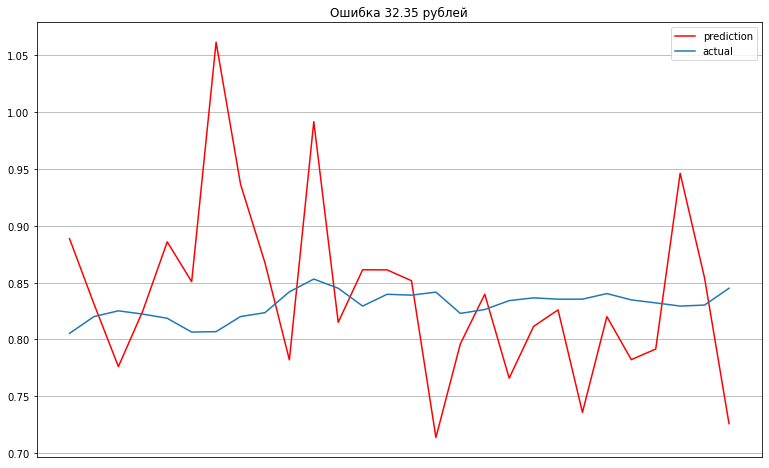

In [218]:
dates = X.index
plt.figure(figsize=(13, 8))
plt.plot(dates,X@w_opt, "r", label="prediction")
plt.plot(dates, y, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Ошибка {32.35} рублей");
plt.xticks([])
plt.show()

"Шоков не было, всё идёт пока что по тренду. Апрель 2024 года оказался спокойным, поэтому прогнозы остаются хорошими." Ну как хорошим. 32.35 рублей - вполне себе ошибка внушительная, если мы торгуем в большом количестве. Это же цена за одну единицу, а если мы вдруг торгуем (что логично) большими объемами ценных бумаг. Берем свои слова назад - на новых данных модель сломалась... Ну оно и понятно, рынок после СВО откатился назад, а мы обучались на кризисе...

# Предсказание обычным решающим деревом

Здесь мы решили написать регрессию при помощи построения дерева решения. Дерево решений будем строить при помощи жадного алгоритма. То есть на каждом шаге выбирать оптимальный придикат с точки зрения минимизации impurity. Здесь, в качестве Impurity была выбрана дисперсия итогового разбиваемого множества $$Q=\dfrac{|R_l|}{|R|} \cdot \sigma^2(R_l)+\dfrac{|R_r|}{|R|}\cdot \sigma^2(R_r) \to \min_t$$

Где R - разбиваемое множество на правую часть $R_r$ и левую часть $R_l$. а t еаш предикат в конкретной вершине. Предикат вида $x_i^j>t$, где $j$ - значение признака $j$ у объекта $i$

Зря что ли машинное обучение проходили? Для начала написали класс отвечающий за подсчет дисперсии в задаче регресии:

In [163]:
class Uncertainty(abc.ABC):
    @abc.abstractmethod
    def calc_uncertainty(self, task, target_vector,feature_vector) -> float:
        pass

In [220]:
class UncertaintyCalc(Uncertainty):
    def count_classes(self, target_vector):
        target_vector = target_vector.astype(int)
        unique, counts = np.unique(target_vector, return_counts=True)
        class_counts = np.zeros(max(unique) + 1)
        class_counts[unique] = counts
        return class_counts

    def calc_uncertainty(self, task, target_vector, feature_vector) -> float:
        if task == 'regression':
            H = (1 / len(feature_vector)) * np.sum((feature_vector - feature_vector.mean()) ** 2)
        return round(H, 2)

    def apply_uncertainty_to_values(self, values):
        uncertainties = []
        for pair in values:
            target_vector = np.concatenate([np.ones(pair[0]), np.zeros(pair[1])])
            feature_vector = target_vector
            uncertainty = self.calc_uncertainty('classification', target_vector, feature_vector)
            uncertainties.append(uncertainty)
        return uncertainties

Данный класс вычисляет меру неопределенности, основанной на дисперсии разбияния, выборочной:
$$\sigma^2(R)=\sum_{x_i \in R}(x_i-\overline{X}_R)^2$$

In [165]:
def apply_thresholds(target_vector: np.ndarray):

    thresholds = np.unique(target_vector)
    matches = thresholds[:, None] == target_vector
    feature_counts = np.sum(matches, axis=1)
    not_feature_counts = target_vector.size - feature_counts
    results = np.vstack((feature_counts, not_feature_counts)).T

    return results

Функция вычисляющая impurity для всевозможных разбиений

Если коротко описать что здесь происходит. У нас есть данные в вершине дерева. Условно (400, 290, 160,...), мы делаем множество порогов, каждый из порогов является средним из ближайших значений отсортированной вершины.  Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются. В качестве порогов берем среднее двух соседних (при сортировке) значений признака. После чего идет перебор всех порогов и выбор предиката вида $x_i > t$ такого, что взвешенная сумма impurity посчитанная на основе дисперсий - минимальна. Об этом будет позже.

In [166]:
def calculate_thresholds(feature_vector: np.ndarray) -> np.ndarray:
    sorted_feature_vector = np.sort(feature_vector)

    thresholds = (sorted_feature_vector[:-1] + sorted_feature_vector[1:]) / 2

    return thresholds

In [167]:
def split_by_thresholds(feature_vector: np.ndarray, thresholds: np.ndarray):
    left_splits = []
    right_splits = []

    for threshold in thresholds:
        left_split = feature_vector[feature_vector <= threshold]
        right_split = feature_vector[feature_vector > threshold]
        left_splits.append(left_split)
        right_splits.append(right_split)

    return np.array(left_splits, dtype=object), np.array(right_splits, dtype=object)

Нижу представлена функция ищущая оптимальная разбиение по этому критерию. Которая на вход принимает вектор значений и классов, а также тип задачи регрессия или классификация. Данный код был написан самостоятельно в рамках 7 домашнего задания по машинному обучению на майноре, можно прогнать будет на антиплагиат, если вдруг такая потребность возникнет. Однако для нужд данного проекта нам не потребуется вычислять классификацию, а также все данные реальны, а не категориальны. Так что частично функция была видоизменена, но "мусора" в виде ненужных частей функцйи немного осталось.

In [168]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:

    uncertainty_calc = UncertaintyCalc()

    feature_vector = feature_vector.astype(float).flatten()
    target_vector = target_vector.astype(float)

    if feature_type == "real":
        thresholds = calculate_thresholds(feature_vector)
        left_masks = feature_vector[:, None] <= thresholds
        right_masks = ~left_masks

        valid_splits = (left_masks.sum(axis=0) > 0) & (right_masks.sum(axis=0) > 0)
        if not any(valid_splits):
            return np.array([]), np.array([]), None, float('inf')

        thresholds = thresholds[valid_splits]
        left_masks = left_masks[:, valid_splits]
        right_masks = right_masks[:, valid_splits]

        left_uncertainties = np.array([
            uncertainty_calc.calc_uncertainty('regression', target_vector[mask], target_vector[mask]) for mask in left_masks.T
        ])
        right_uncertainties = np.array([
            uncertainty_calc.calc_uncertainty('regression', target_vector[mask], target_vector[mask]) for mask in right_masks.T
        ])

        left_sizes = left_masks.sum(axis=0)
        right_sizes = right_masks.sum(axis=0)

        weighted_uncertainties = (left_uncertainties * left_sizes + right_uncertainties * right_sizes) / (left_sizes + right_sizes)

        best_index = np.argmin(weighted_uncertainties)
        best_threshold = thresholds[best_index]
        best_uncertainty = weighted_uncertainties[best_index]

        return thresholds, weighted_uncertainties, best_threshold, best_uncertainty

    else:
        raise ValueError("Неверный тип данных)")


Класс, предназначенный для постройки дерева жадным алгоритмом.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [178]:
class DecisionTree:
    def __init__(self, feature_types: List[str], task: str, max_depth: int = 10):
        self._feature_types = feature_types
        self.task = task
        self.max_depth = max_depth
        self._tree = {}

    def _fit_node(self, sub_X: np.ndarray, sub_y: np.ndarray, node: dict, depth: int) -> None:
        if np.unique(sub_y).size == 1:
            node["type"] = "terminal"
            node["class_label"] = sub_y[0]
            return
        
        if depth >= self.max_depth:
            node["type"] = "terminal"
            node["class_label"] = np.mean(sub_y) if self.task == "regression" else np.bincount(sub_y).argmax()
            return

        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            feature_vector = sub_X[:, feature]

            _, _, threshold, gini = find_best_split(feature_vector, sub_y, feature_type=feature_type)

            if gini < best_gini:
                best_gini = gini
                best_feature = feature
                best_threshold = threshold

        if best_feature is None:
            node["type"] = "terminal"
            node["class_label"] = np.mean(sub_y) if self.task == "regression" else np.bincount(sub_y).argmax()
            return

        node["type"] = "nonterminal"
        node["split_feature"] = best_feature
        node["threshold"] = best_threshold

        left_indices = sub_X[:, best_feature] <= best_threshold
        right_indices = sub_X[:, best_feature] > best_threshold

        node["left_child"] = {}
        node["right_child"] = {}

        self._fit_node(sub_X[left_indices], sub_y[left_indices], node["left_child"], depth + 1)
        self._fit_node(sub_X[right_indices], sub_y[right_indices], node["right_child"], depth + 1)

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree, depth=0)

    def _predict_node(self, x: np.ndarray, node: dict) -> float:
        if node["type"] == "terminal":
            return node["class_label"]

        if x[node["split_feature"]] <= node["threshold"]:
            return self._predict_node(x, node["left_child"])
        else:
            return self._predict_node(x, node["right_child"])

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self._predict_node(x, self._tree) for x in X])

In [182]:
X_train.head()

,NUMTRADES_x,VALUE,OPEN,LOW,HIGH,CLOSE,VOLUME,TRENDCLSPR_x,IMOEX_CLOSE,IMOEX_OPEN,...,SI_OPE,SI_HIGH,SI_LOW,TRENDCLSPR_y,NUMTRADES_y,TradingVolume_RUB,TradingVolume_CONTR,OpenPositionsVolum_RUB,OpenPositionsVolum_CONTR,MarginRequirements
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2024-04-09,0.148700,0.072849,0.785626,0.844331,0.780423,0.782440,0.050526,0.661599,0.631621,0.655572,...,0.821187,0.817589,0.889175,0.476696,-0.010747,0.017617,0.007039,0.985074,0.818893,0.897947
2024-05-07,0.079519,0.021906,0.797170,0.873323,0.800957,0.811373,0.012808,0.684497,0.637253,0.648540,...,0.780898,0.771560,0.841334,0.447198,0.003059,0.028003,0.017279,1.076896,0.925205,0.861352
2024-04-19,0.117563,0.054250,0.804245,0.870943,0.811162,0.824900,0.035875,0.701577,0.655506,0.669745,...,0.828178,0.821340,0.882644,0.424779,0.018922,0.059676,0.041834,1.028571,0.861252,0.898376
2024-05-06,0.099851,0.035263,0.804245,0.872241,0.805493,0.809118,0.022380,0.670983,0.640813,0.662885,...,0.786960,0.781682,0.840201,0.435398,0.019706,0.052073,0.037454,1.079246,0.926421,0.863757
2024-04-29,0.038390,0.007760,0.803749,0.878083,0.799950,0.819389,0.002595,0.687875,0.658543,0.673767,...,0.803184,0.808426,0.871085,0.484956,-0.009663,0.006700,-0.001604,1.071098,0.901364,0.892965


In [183]:
X_train_np = X_train.values
y_train_np = y_train.values

feat_types = ['real'] * X_train_np.shape[1]

decision_tree = DecisionTree(feature_types=feat_types, task="regression")
decision_tree.fit(X_train_np, y_train_np)

y_pred = decision_tree.predict(X_train_np)

mse = np.mean((y_pred - y_train_np) ** 2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 9.876531699915846e-05


Давайте протестируем модель на новых данных:

Сначала мы обучили модель на данных с 1 января 2021 по 1 апреля 2024. Давайте теперь посмотрим, как наша модель справляется на совершенно новых данных с 1 апреля 2024 по 15 мая 2024.

In [188]:
y = df_ROSN_Final_normalized_custom['WAPRICE']
X = df_ROSN_Final_normalized_custom.drop('WAPRICE', axis = 1)

In [192]:
X_train_np = X.values
y_train_np = y.values

feat_types = ['real'] * X_train_np.shape[1]

decision_tree = DecisionTree(feature_types=feat_types, task="regression")
decision_tree.fit(X_train_np, y_train_np)

y_pred = decision_tree.predict(X_train_np)

mse = np.mean((y_pred - y_train_np) ** 2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.00011372478773241135


In [194]:
z = 0.00011372478773241135

In [196]:
print(f"Ошибка в руб = {(z*(b['WAPRICE']-a['WAPRICE'])**2)**(0.5)}")

Ошибка MSE в руб = 4.215551330000971


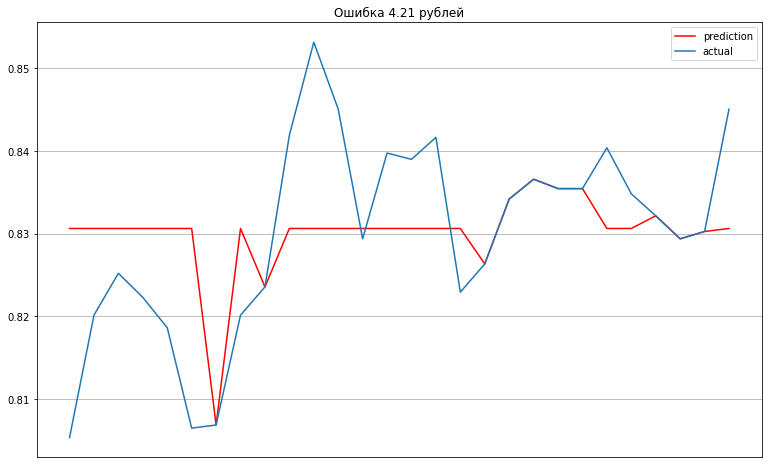

In [219]:
dates = np.arange(len(y_train_np))

plt.figure(figsize=(13, 8))
plt.plot(dates, y_pred, "r", label="prediction")
plt.plot(dates, y_train_np, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Ошибка {4.21} рублей")
plt.xticks([])
plt.show()

# Random Forest

Теперь попробуем построить модель, основанную на методе случайного леса. Мы построим множество сильно переобученных в плане глубины решающих деревьев, но эта переобученность будет компенсирована случайными подпространствами и бустрапом. Гиперпараметрами в данной задаче будут выступать количество деревьев, максимальная глубина, минимальное количество образцов для разделения узла, минимальное количество образцов в листовом узле. Для начала решили взять количество деревьев равное 50: $N=50$. Просто ради интереса... На самом деле есть результат в силу которого Random Forest не имеет тенденцию к переобучению по мере роста N, так что N особо подбирать не нужно. Мы взяли 50, но можно было бы взять 100, 1000, переобучения не будет.

В данном коде, который использует RandomForestRegressor, агрегация решений происходит путем усреднения предсказаний всех деревьев в лесу.
$$y_{pred} = \dfrac{\sum_{i=1}^Ny_i}{N}$$

Сначала мы обучили модель на данных с 1 января 2021 по 1 апреля 2024. Давайте теперь посмотрим, как наша модель справляется на совершенно новых данных с 1 апреля 2024 по 15 мая 2024.

In [229]:
base_estimator = DecisionTreeRegressor(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], random_state=0)

bagging_regressor = BaggingRegressor(base_estimator=base_estimator, n_estimators=50, random_state=0)
bagging_regressor.fit(X_train, y_train)

y_pred_bagging = bagging_regressor.predict(X)


metrics_bagging = {
    'MSE': mean_squared_error(y, y_pred_bagging),
    'MAE': mean_absolute_error(y, y_pred_bagging)}

for metric, value in metrics_bagging.items():
    print(f"BaggingRegressor {metric}: {value}")

BaggingRegressor MSE: 1.6764298731336045e-05
BaggingRegressor MAE: 0.0028041993422716826


In [232]:
z = mean_squared_error(y, y_pred_bagging)

In [233]:
print(f"Ошибка в руб = {(z*(b['WAPRICE']-a['WAPRICE'])**2)**(0.5)}")

Ошибка MSE в руб = 1.6185253649983118


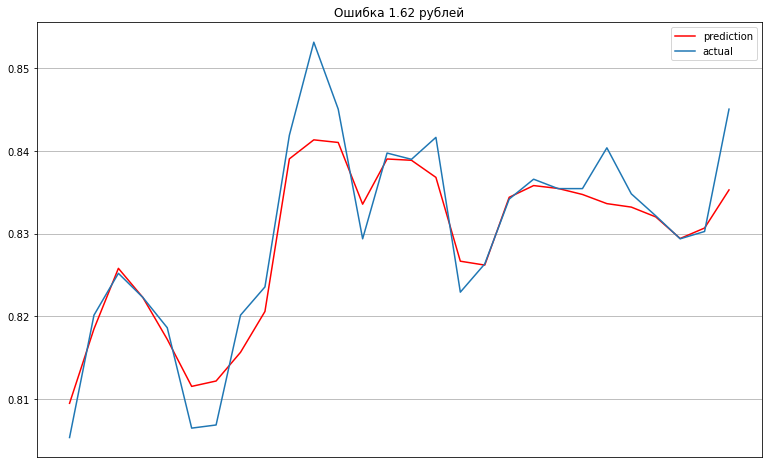

In [236]:
dates = np.arange(len(y_train_np))

plt.figure(figsize=(13, 8))
plt.plot(dates, y_pred_bagging, "r", label="prediction")
plt.plot(dates, y, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Ошибка {1.62} рублей")
plt.xticks([])
plt.show()

А давайте будем еще подбирать гиперпараметры `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями посредством кросс валидации. Так как у нас немного данных, давайте проведем кросс-валидацию с делением нашей выборки на 10 блоков: (Объясним как работает Кросс-валидация на частном примере с 3 блоками (3-кратная кросс-валидация) — это метод оценки модели, при котором исходные данные разделяются на три части. Каждая часть поочерёдно используется в качестве тестовой выборки, а оставшиеся данные — в качестве обучающей выборки.) Использование кросс - валидации хоть и может быть неоправдано маленьким размером выборки, но с другой стороны мы будем включать данные в период СВО (похожие на вывбросы) несколько раз как и в обучающую, так и в тесновую выборки.

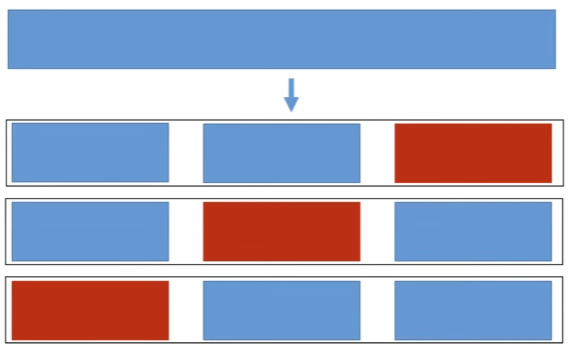

После чего считается loss на каждой кросс-валидационной модели: $Q_i$, где $i \in \{1,2,\dots,N\}$.  После чего гиперпараметр выбирается на основе минимизации: $$\dfrac{Q_1(k)+\dots +Q_N(k)}{N} \to \min_k$$
И оптимальным гиперпараметром будет тот на котором средняя ошибка по кросс-валидации будет минимальной

In [271]:
y = df_ROSN_Final[5]
X = df_ROSN_Final.drop(5, axis = 1)

In [254]:
X_train_np = X.values
y_train_np = y.values

max_depth_values = np.arange(1, 20)
min_samples_leaf_values = np.arange(1, 20)

param_grid = {
    'max_depth': max_depth_values,
    'min_samples_leaf': min_samples_leaf_values
}

rf = RandomForestRegressor(n_estimators=50, random_state=42)

loo = LeaveOneOut()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_np, y_train_np)

best_params = grid_search.best_params_
best_mse_score = -grid_search.best_score_

print(f"Лучшие гиперпараметры: {best_params}")
print(f"Лучшее среднее значение MSE на кросс-валидации: {best_mse_score}")

Лучшие гиперпараметры: {'max_depth': 12, 'min_samples_leaf': 3}
Лучшее среднее значение MSE на кросс-валидации: 0.0003870648516148492
RandomForest MSE: 6.428666765413412e-06
RandomForest MAE: 0.002035951622278382


In [272]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, **best_params)
rf.fit(X_train_np, y_train_np)

RandomForestRegressor(max_depth=12, min_samples_leaf=3, n_estimators=50,
                      random_state=42)

Сначала мы обучили модель на данных с 1 января 2021 по 1 апреля 2024. Давайте теперь посмотрим, как наша модель справляется на совершенно новых данных с 1 апреля 2024 по 15 мая 2024.

In [278]:
y = df_ROSN_Final_normalized_custom['WAPRICE']
X = df_ROSN_Final_normalized_custom.drop('WAPRICE', axis = 1)

In [279]:
y_test_pred_rf = rf.predict(X)
metrics_rf = {
    'MSE': mean_squared_error(y, y_test_pred_rf),
    'MAE': mean_absolute_error(y, y_test_pred_rf),}

for metric, value in metrics_rf.items():
    print(f"RandomForest {metric}: {value}")

RandomForest MSE: 5.279628548193745e-06
RandomForest MAE: 0.001964792353364731


In [280]:
z = mean_squared_error(y, y_test_pred_rf)

In [281]:
print(f"Ошибка в руб = {(z*(b['WAPRICE']-a['WAPRICE'])**2)**(0.5)}")

Ошибка в руб = 0.9082982942648413


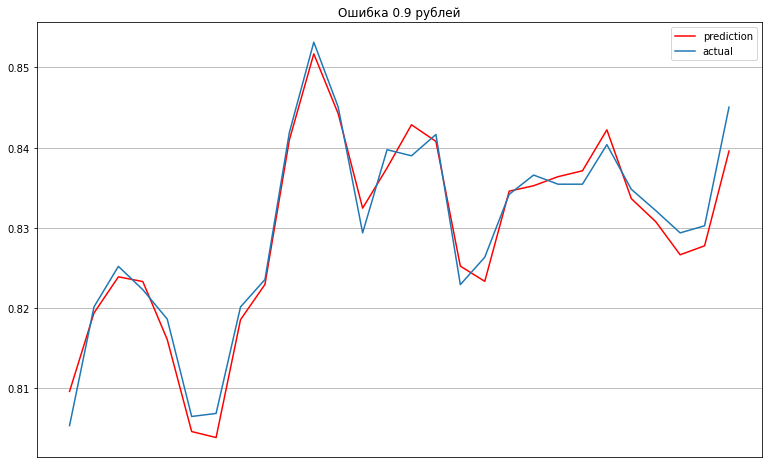

In [283]:
dates = np.arange(len(y))

plt.figure(figsize=(13, 8))
plt.plot(dates, y_test_pred_rf, "r", label="prediction")
plt.plot(dates, y, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Ошибка {0.9} рублей")
plt.xticks([])
plt.show()

# Выводы

Линейная модель обученная градиентным спуском показала ошибку в 32 рубля. Это указывает на то, что линейная модель не может адекватно описать зависимости в данных и не является достаточно гибкой для данной задачи.
Модель, обученная решающим деревом, показала ошибку в 4 рубля. Это значительно лучшее качество, что свидетельствует о том, что решающие деревья лучше справляются с нелинейными зависимостями и могут лучше учитывать сложные взаимодействия между признаками.
Особенно в ситуации, когда есть явные отклонения от нормы (Февраль 2022)

Линейная модель ограничена тем, что она может представлять только линейные зависимости. В случае сложных данных, где взаимосвязи между признаками и целевой переменной могут быть нелинейными, линейная модель не способна адекватно моделировать такие зависимости.

Решающее дерево является более гибким методом, способным моделировать нелинейные зависимости. Жадный алгоритм построения дерева позволяет находить локально оптимальные разбиения, что может привести к более точному прогнозированию в случае сложных данных.
Качество предсказания:

Для задач прогнозирования стоимости акций, где зависимость может быть сложной и нелинейной, рекомендуется использовать более гибкие модели, такие как решающие деревья, ансамблевые методы (например, случайный лес, градиентный бустинг) или нейронные сети.

Линейные модели могут использоваться в качестве базового подхода, но в случае низкого качества предсказаний следует рассмотреть использование более сложных моделей.

Данные о котировках "Сбера" оказались менее полезными для наших моделей, и во всех случаях модели использовали их в меньшей степени. Причину этого мы будем изучать в дальнейших исследованиях и проверке гипотез о зависимости различных факторов. Возможно, требуется более детальный анализ взаимосвязи данных "Сбера" с другими переменными, чтобы лучше понять их влияние на предсказания моделей.

Таким образом, основные выводы заключаются в том, что для данной задачи линейная модель не подходит из-за своей простоты и неспособности моделировать нелинейные зависимости, тогда как решающее дерево показало себя как более подходящая модель с приемлемым качеством предсказания.

Наилучший результат показала модель случайного леса с гиперпараметрами, подобранными по кросс-валидации на 10 блоках.

Для предсказания котировок с использованием нашей модели мы можем применить несколько методов для предварительной обработки данных, чтобы улучшить качество прогнозов. Вот несколько подходов:

Усреднение данных за несколько дней: Мы можем взять средние значения котировок за несколько дней, чтобы сгладить колебания и шум в данных. Это поможет модели лучше уловить общие тенденции.

Скользящая средняя: Применение скользящей средней позволяет уменьшить влияние краткосрочных колебаний и выявить долгосрочные тренды. Скользящая средняя рассчитывается как среднее значение котировок за определенный период времени (например, 7 или 14 дней), и это значение обновляется каждый день.

После чего на полученных путем применения одного из двух методов признаков, подставить их в обученную модель и попытаться предсказать среднюю стоимость акций компании Росснефть за торговую сессию... Может быть вдальнейшем так сделаем. Возьмем данные о признаках за последние пару дней, усредним их и посмотрим на то, насколько сильно модель ошиблась...